# Clustering and visualization on the GloVe embeddings for each word

## Imports related to embedding

In [1]:
class Glove_Embedder:
    def __init__(self, PATH_TO_TEXTFILE):
        self.glove_embeddings_dict = {}
        glove_embeddings_file = open(PATH_TO_TEXTFILE, 'r')
        firstTime = True
        while True:
            line = glove_embeddings_file.readline()
            if not line:
                break
            splitted = line.split()
            key = splitted[0]
            value = np.array([float(i) for i in splitted[1:]])
            if(firstTime):
                firstTime = False 
                self.embedding_vector_size = value.size
            self.glove_embeddings_dict[key] = value
        glove_embeddings_file.close()
    def get_embedding_for_sentence(self, sentence_list):
        '''
        The sentence should be lowercased and free of special characters and numbers. Ideally, it should be lemmatized, too. The sentence should be a list of words.
        '''
        number_of_words = len(sentence_list)
        embedding = np.zeros((self.embedding_vector_size, ))
        if(number_of_words == 0):
            return embedding 
        for word in sentence_list:
            if word in self.glove_embeddings_dict:
                embedding += self.glove_embeddings_dict[word]
        embedding /= number_of_words
        return embedding.tolist()
    def get_embedding_for_word(self, word):
        if word in self.glove_embeddings_dict:
            embedding = self.glove_embeddings_dict[word]
        else:
            embedding = np.zeros((self.embedding_vector_size, ))
        return embedding.tolist()

## Other imports

In [2]:
import time
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
import gc
from tqdm import tqdm 
tqdm.pandas()

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

train_dset_df = pd.read_csv("2020_10_19_train_dset_df_nostem_nostoprem.csv")
test_dset_df = pd.read_csv("2020_10_19_test_dset_df_nostem_nostoprem.csv")
train_dset_df["preprocessed_joined"].fillna("", inplace=True)
test_dset_df["preprocessed_joined"].fillna("", inplace=True)

vectorizer = CountVectorizer()
vectorizer.fit(train_dset_df["preprocessed_joined"])
original_sparse_train_x = vectorizer.transform(train_dset_df["preprocessed_joined"])
original_sparse_test_x  = vectorizer.transform(test_dset_df["preprocessed_joined"])
train_dset_y = train_dset_df["target"].to_numpy()

def summarize(y, yhat):
    '''
    y and yhat are both 1-dimensional ndarrays where every entry is either 0 or 1. 
    y and yhat must have the same size 
    '''
    print("Number of zeros in y:", np.sum( (y == 0).astype(int) ))
    print(" Number of ones in y:", np.sum((y == 1).astype(int)))
    print("            F1 score:", f1_score(y, yhat))
    print(" # of zeros wrong yh:", np.sum(np.logical_and(y == 0, yhat == 1).astype(int)))
    print("  # of ones wrong yh:", np.sum(np.logical_and(y == 1, yhat == 0).astype(int)))

## Stopword removal

In [8]:
import nltk

In [9]:
class Stopword_Remover:
    def __init__(self):
        self.stopwordCorpus = set(nltk.corpus.stopwords.words())
    def stopword_removed(self, sentence_str):
        return " ".join([word for word in sentence_str.split(" ") if not word in self.stopwordCorpus])

In [10]:
srem = Stopword_Remover()

In [13]:
train_dset_df["preprocessed_joined"] = train_dset_df["preprocessed_joined"].progress_apply(srem.stopword_removed)

100%|██████████| 783673/783673 [00:02<00:00, 319385.83it/s]


In [14]:
train_dset_df["preprocessed_joined"]

0         reply comment india poor fact understand unnec...
1                          use transportation ancient india
2                                 important provision obama
3                            age finns master english today
4            cheap place live india month best suit tourism
                                ...                        
783668                                 cause lump back head
783669                                standalone simple way
783670                       prevent low potassium pregnant
783671                        like meet band imagine dragon
783672    find intelligent well reason person discuss co...
Name: preprocessed_joined, Length: 783673, dtype: object

In [17]:
unique_words_list = sorted(list(set((" ".join(train_dset_df["preprocessed_joined"].tolist())).split(" "))))

## Embedding

In [19]:
embedder = Glove_Embedder("./embeddings/glove/glove.6B.50d.txt")

In [31]:
embedded_words_list = []
embeddings_list = []
for word in unique_words_list:
    curr_embedding = embedder.get_embedding_for_word(word)
    if not(np.all(np.array(curr_embedding) == 0)):
        embedded_words_list.append(word)
        embeddings_list.append(curr_embedding)

## T-SNE

In [35]:
from sklearn.manifold import TSNE

In [49]:
tsne = TSNE(n_jobs=6, verbose=3, perplexity=100, n_iter=5000)

In [50]:
embeddings_np = np.array(embeddings_list)

In [51]:
tsnified_dset = tsne.fit_transform(embeddings_np)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 52857 samples in 0.318s...
[t-SNE] Computed neighbors for 52857 samples in 120.573s...
[t-SNE] Computed conditional probabilities for sample 1000 / 52857
[t-SNE] Computed conditional probabilities for sample 2000 / 52857
[t-SNE] Computed conditional probabilities for sample 3000 / 52857
[t-SNE] Computed conditional probabilities for sample 4000 / 52857
[t-SNE] Computed conditional probabilities for sample 5000 / 52857
[t-SNE] Computed conditional probabilities for sample 6000 / 52857
[t-SNE] Computed conditional probabilities for sample 7000 / 52857
[t-SNE] Computed conditional probabilities for sample 8000 / 52857
[t-SNE] Computed conditional probabilities for sample 9000 / 52857
[t-SNE] Computed conditional probabilities for sample 10000 / 52857
[t-SNE] Computed conditional probabilities for sample 11000 / 52857
[t-SNE] Computed conditional probabilities for sample 12000 / 52857
[t-SNE] Computed conditional probabilities for 

100%|██████████| 1000/1000 [00:00<00:00, 20289.49it/s]


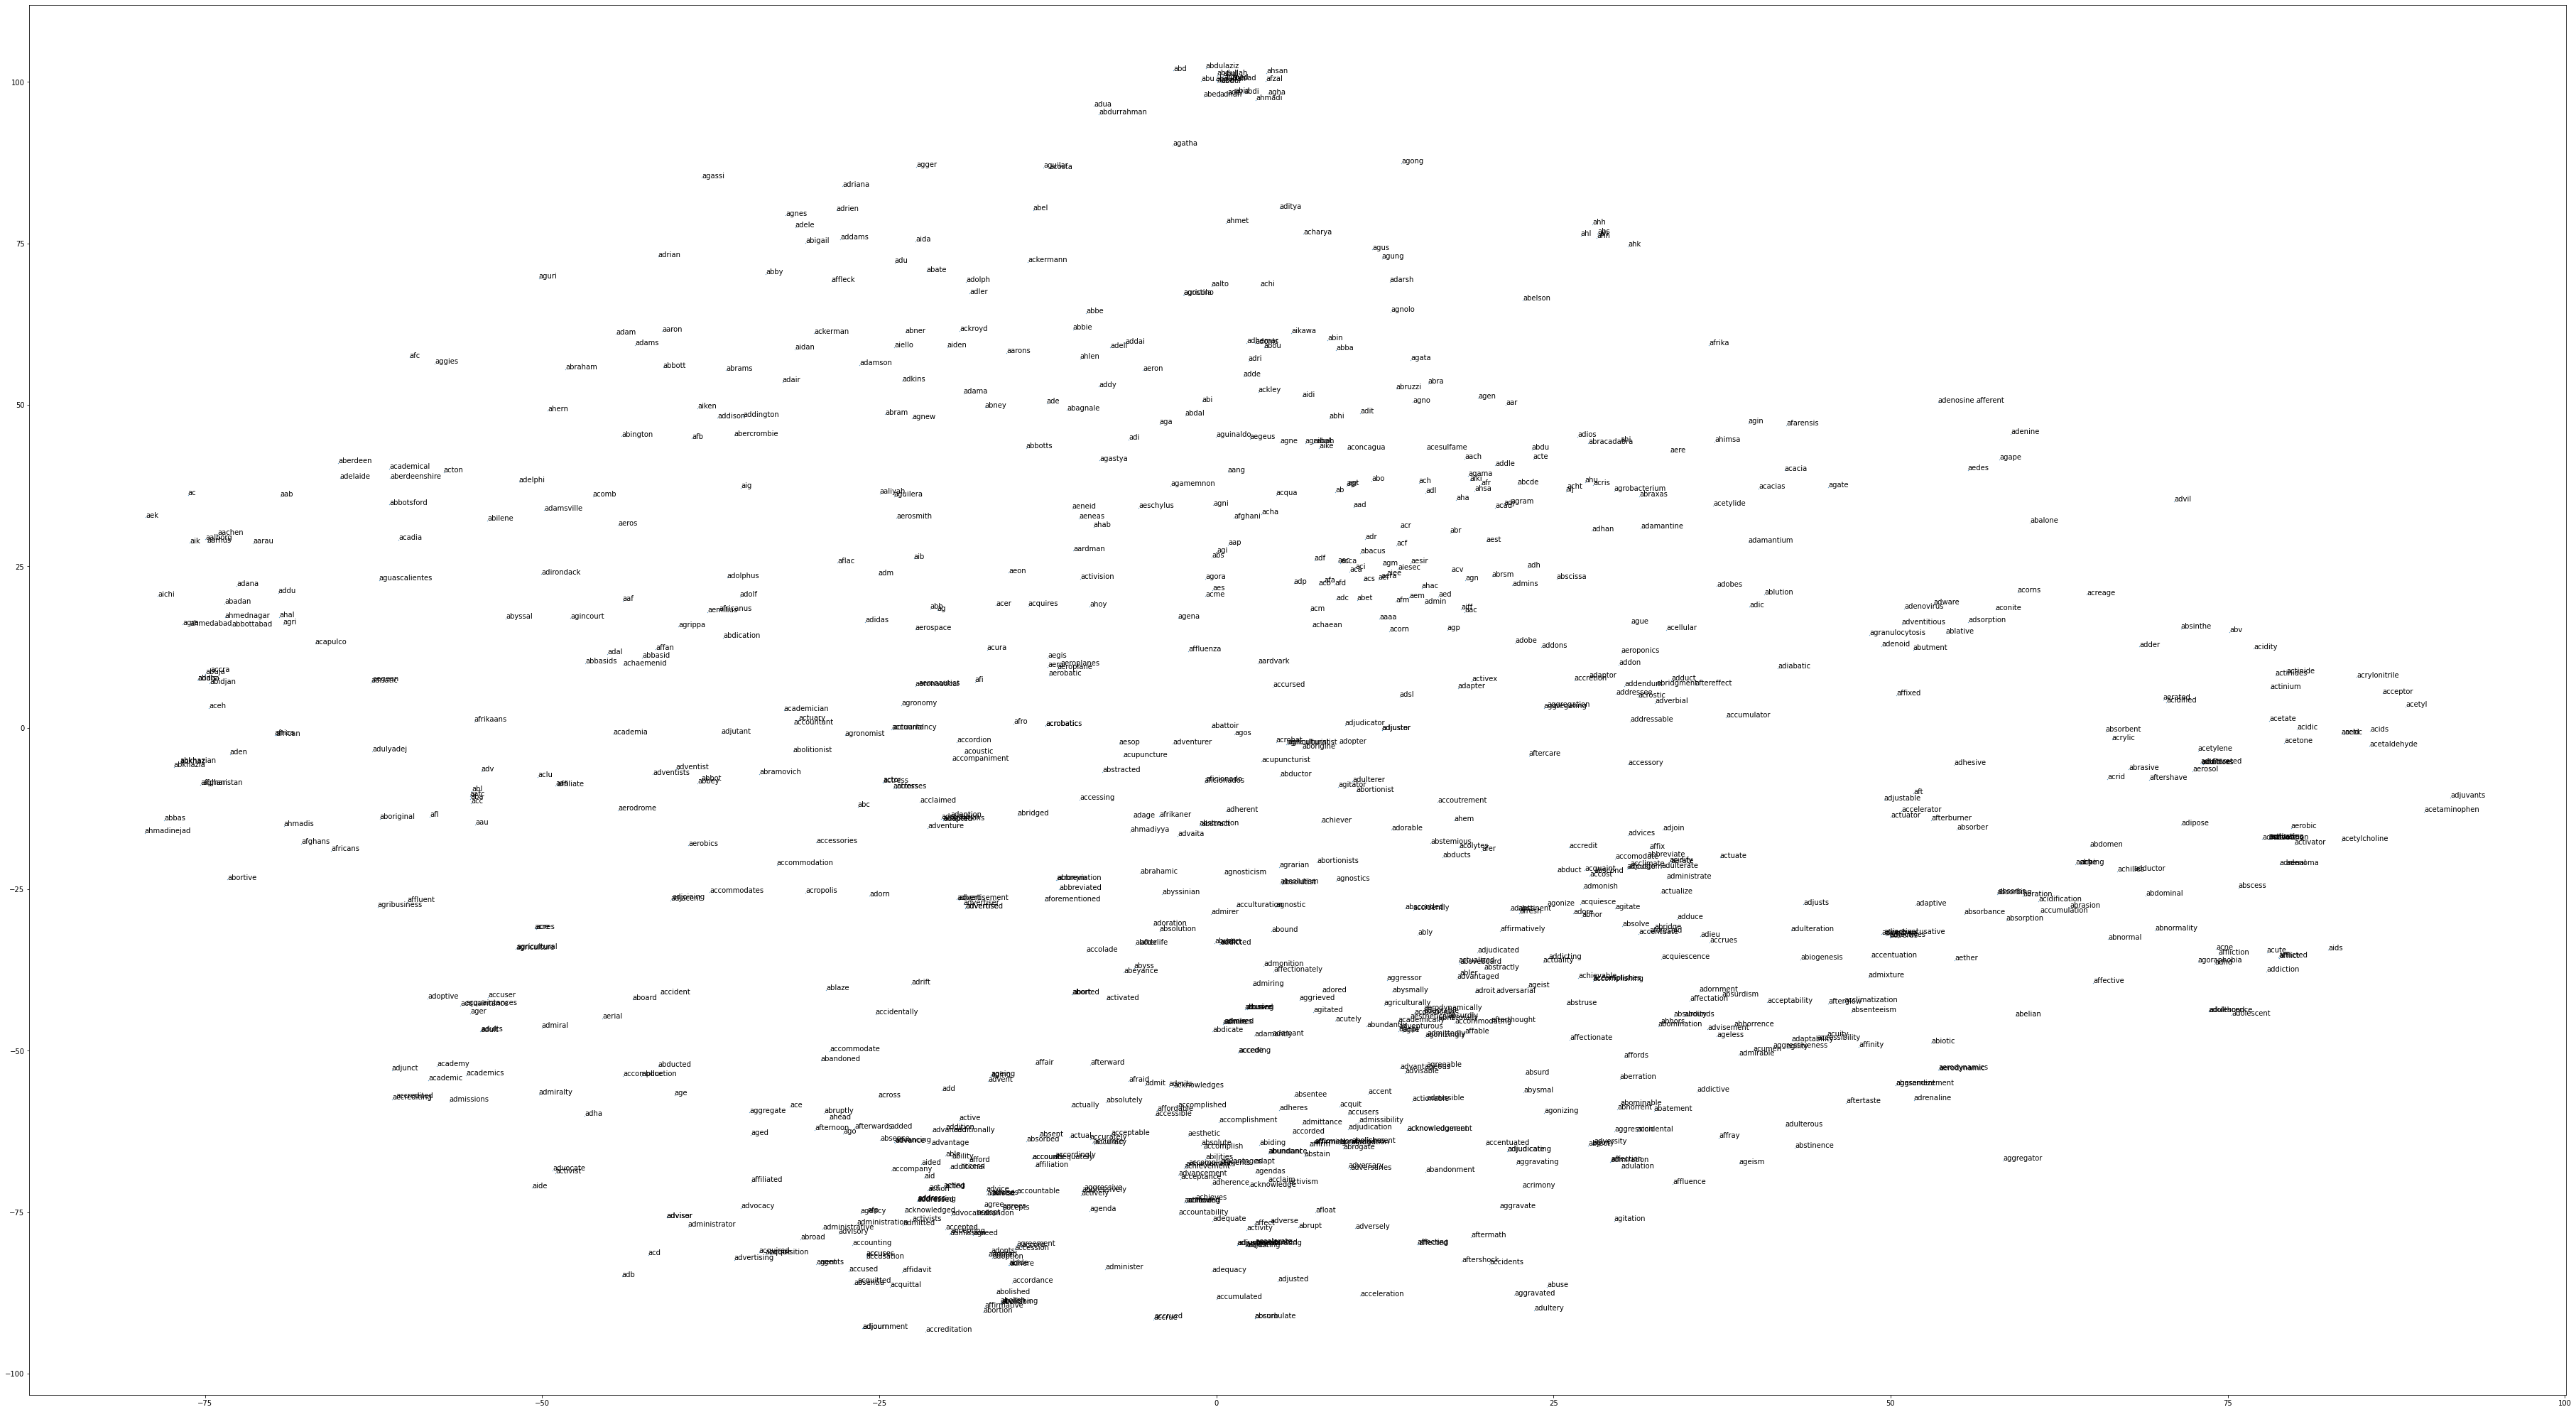

In [70]:
fig = plt.figure(figsize=(64, 36))
PLT_POINTS_NUM = 1000
plt.scatter(tsnified_dset[:PLT_POINTS_NUM,0], tsnified_dset[:PLT_POINTS_NUM,1], s=0.1)
for i in tqdm(range(PLT_POINTS_NUM)):
    plt.annotate(embedded_words_list[i], (tsnified_dset[i, 0], tsnified_dset[i,1]))
plt.savefig("tsnified.png")